In [164]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

### Model

In [57]:
np.random.seed(1234)

In [58]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (120, 120, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(300, activation = 'relu'))
model.add(layers.Dense(18, activation = 'softmax'))

model.summary()

c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │       960,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,550 (4.60 MB)

 Trainable params: 1,206,550 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

### Building Image Folders

In [60]:
pkm_path = '../data/pokemon_types.csv'
pkm_img_path = '../data/images'

pkm = pd.read_csv(pkm_path)
pkm.head(3)

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison


In [61]:
X_train, X_test, y_train, y_test = train_test_split(pkm['Name'], pkm['Type1'], test_size = 0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [62]:
for df in [X_train, y_train, X_val, y_val, X_test, y_test]:
    print(len(df), end = '\n')

517
517
130
130
162
162


In [63]:
def image_keras_creator(pkm_img_path, new_dir):
    os.mkdir(new_dir)
    
    for d in ['train', 'test', 'validation']:
        folder = new_dir + '/' + d
        os.mkdir(folder)
        
        for t in pkm['Type1'].unique():
            type_folder = folder + '/' + t
            os.mkdir(type_folder)
            
    residual = []
    
    for img in os.listdir(pkm_img_path):
        if '.png' in img:
            pkm_name = img.replace('.png', '')
        elif ',jpg' in img:
            pkm_name = img.replace('jpg', '')
            
        if pkm_name not in pkm['Name'].to_numpy():
            residual.append(img)
            continue
        file_path = pkm_img_path + '/' + img
        
        if pkm_name in X_train.to_numpy():
            new_file = new_dir + '/' + 'train' + '/' + \
                pkm.loc[pkm['Name'] == pkm_name, 'Type1'].to_numpy()[0] + '/' + img
            shutil.copy2(file_path, new_file)
            
        if pkm_name in X_val.to_numpy():
            new_file = new_dir + '/' + 'validation' + '/' + \
                pkm.loc[pkm['Name'] == pkm_name, 'Type1'].to_numpy()[0] + '/' + img
            shutil.copy2(file_path, new_file)
            
        if pkm_name in X_test.to_numpy():
            new_file = new_dir + '/' + 'test' + '/' + \
                pkm.loc[pkm['Name'] == pkm_name, 'Type1'].to_numpy()[0] + '/' + img
            shutil.copy2(file_path, new_file)
            
    print('Unused:', residual, '\n')
        
        
        

In [ ]:
new_dir = '../data/pokemon_image_keras'

image_keras_creator(pkm_img_path, new_dir)

Unused: [] 



### Data Preprocessing

In [65]:
train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [66]:
train_generator = train_datagen.flow_from_directory(
    directory = new_dir + '/' + 'train',
    target_size = (120, 120),
    batch_size = 10,
    class_mode = 'categorical')

Found 502 images belonging to 18 classes.


In [67]:
validation_generator = validation_datagen.flow_from_directory(
    directory = new_dir + '/' + 'validation',
    target_size = (120, 120),
    batch_size = 10,
    class_mode = 'categorical')

Found 135 images belonging to 18 classes.


In [68]:
for data_batch, labels_batch in train_generator:
    print(data_batch.shape, "\n")
    print(labels_batch.shape, "\n")
    break

(10, 120, 120, 3) 

(10, 18) 



c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Callbacks

In [69]:
earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    patience = 10,
    verbose = 1,
    mode = 'auto'
)

In [70]:
csv_logger = CSVLogger('../output/logs/training.log',
                       separator = ',',
                       append = False)

### Fitting the Model

In [71]:
models_folder = '../output/models'

In [72]:
history = model.fit(
    train_generator,
    steps_per_epoch = 52,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 13,
    callbacks = [earlystop, csv_logger]
)  

Epoch 1/30


c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.1126 - loss: 2.8608

c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.1126 - loss: 2.8599 - val_accuracy: 0.2154 - val_loss: 2.7177
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.1389 - loss: 2.7217 - val_accuracy: 0.2077 - val_loss: 2.7232
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.1700 - loss: 2.6542 - val_accuracy: 0.1154 - val_loss: 2.6901
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.1414 - loss: 2.6263 - val_accuracy: 0.1154 - val_loss: 2.6653
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.2366 - loss: 2.3598 - val_accuracy: 0.2308 - val_loss: 2.6936
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.3220 - loss: 2.2137 - val_accuracy: 0.1923 - val_loss: 2.6734
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.3855 - loss: 1.9124 - val_accuracy: 0.2000 - val_loss: 2.9272
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5407 - loss: 1.4196 - val_accuracy: 0.1923 - val_loss: 3.

In [73]:
model.save(models_folder + '/CNN_01.keras')

### Plot the Accuracy of the Model

In [74]:
%matplotlib inline

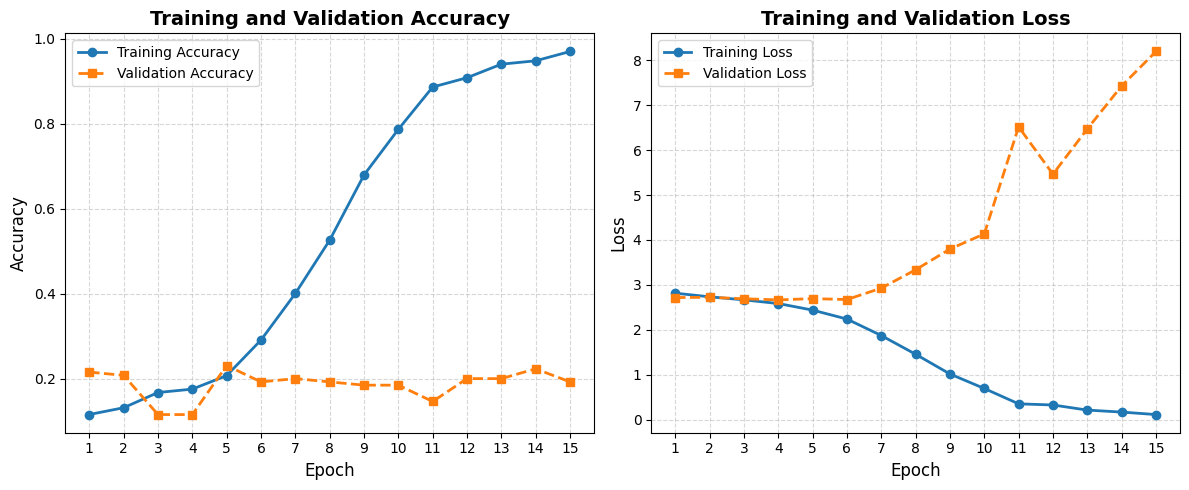

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color = 'tab:blue', label = 'Training Accuracy', linewidth = 2, markersize = 6)
plt.plot(epochs, val_acc, 's--', color = 'tab:orange', label = 'Validation Accuracy', linewidth = 2, markersize = 6)
plt.title('Training and Validation Accuracy', fontsize = 14, fontweight = 'bold')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.xticks(epochs)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color = 'tab:blue', label = 'Training Loss', linewidth = 2, markersize = 6)
plt.plot(epochs, val_loss, 's--', color = 'tab:orange', label = 'Validation Loss', linewidth = 2, markersize = 6)
plt.title('Training and Validation Loss', fontsize = 14, fontweight = 'bold')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.xticks(epochs)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.tight_layout()
plt.show()


In [79]:
log_data = pd.read_csv('../output/logs/training.log', sep = ',', engine = 'python')
log_data

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.115538,2.814725,0.215385,2.717729
1,1,0.131474,2.734166,0.207692,2.723179
2,2,0.167331,2.665848,0.115385,2.690077
3,3,0.175299,2.584260,0.115385,2.665307
4,4,0.207171,2.438029,0.230769,2.693598
5,5,0.290837,2.238508,0.192308,2.673362
6,6,0.400398,1.871917,0.200000,2.927193
7,7,0.525896,1.454914,0.192308,3.335875
8,8,0.679283,1.015197,0.184615,3.797750
9,9,0.786853,0.692341,0.184615,4.135337


Overfitting is evident.

Indeed, we have very few samples (517) and many categories (18). So we try using data augmentation.

In [83]:
datagen = ImageDataGenerator(
      rotation_range = 40,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True,
      fill_mode = 'nearest')

In [92]:
#choose an image of a training water-type pokemon
d = new_dir + '/' + 'train' + '/' + 'Water'
names = [os.path.join(d, name) for name in os.listdir(d)]
name = np.random.choice(names)

PNG
(120, 120)
RGBA
uint8
(120, 120, 4)


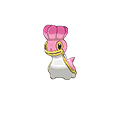

In [93]:
#Method 1
from PIL import Image

img = Image.open(name)
print(img.format)
print(img.size)
print(img.mode)
print(np.asarray(img).dtype) 
print(np.asarray(img).shape)
img

float32
(120, 120, 4)


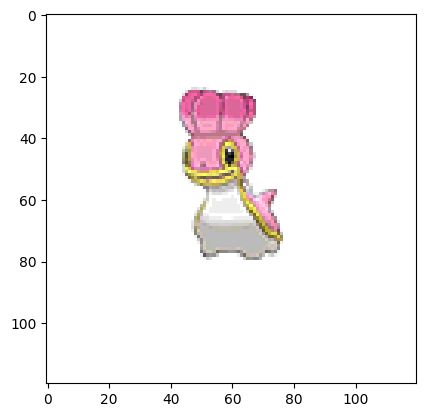

In [ ]:
#Method 2
img = plt.imread(name)
print(img.dtype)
print(img.shape)
plt.imshow(img)
plt.show()

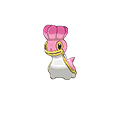

In [96]:
#Method 3
from keras.utils import load_img

img = load_img(name, color_mode = 'rgba', target_size = (120, 120))
#Returns PIL Image instance
img

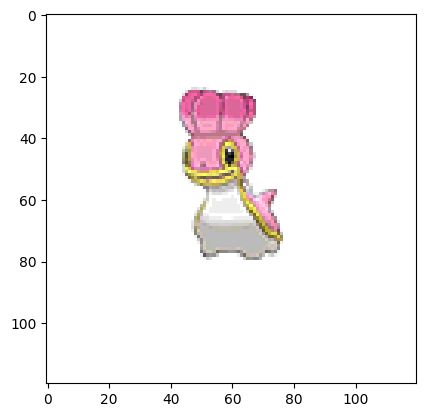

In [98]:
plt.imshow(img)
plt.show()

(120, 120, 4)


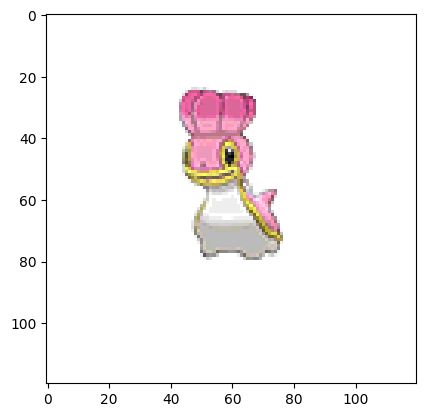

In [100]:
img = np.asarray(img)
print(img.shape)
plt.imshow(img)
plt.show()

In [104]:
img = img[np.newaxis, ...]

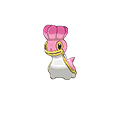

In [ ]:
from tensorflow.keras.utils import array_to_img
array_to_img(img[0])

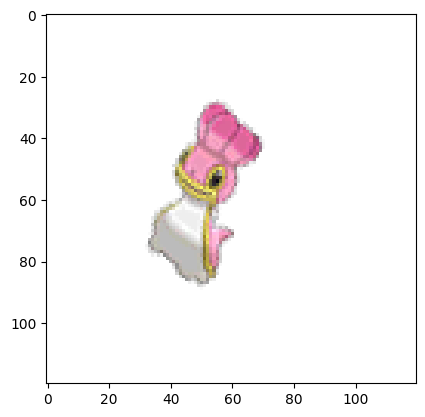

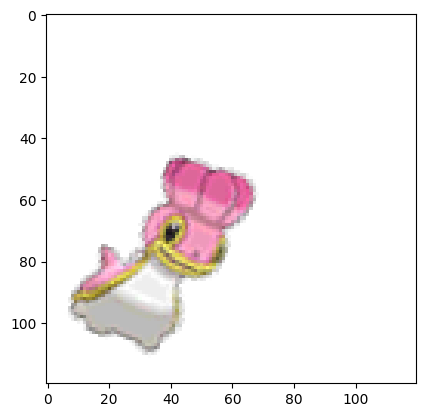

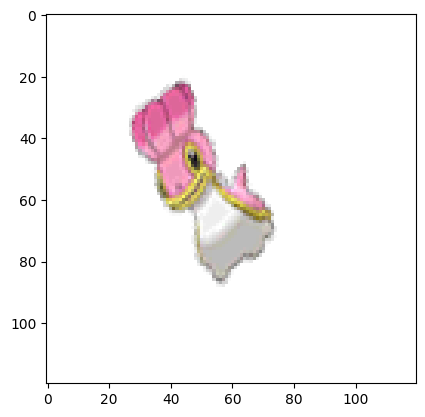

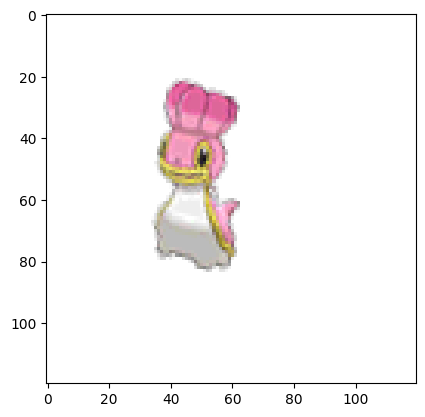

In [108]:
i = 0

for batch in datagen.flow(img, batch_size = 1):
    plt.figure(i)
    b = batch[0]
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i == 4:
        break

plt.show()

To further reduce overfit we add a Dropout layer to our model:

In [109]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (120, 120, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(300, activation = 'relu'))
model.add(layers.Dense(18, activation = 'softmax'))

model.summary()

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 300)            │       960,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,550 (4.60 MB)

 Trainable params: 1,206,550 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

In [110]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# The validation data should not be augmented.
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory = new_dir + '/' + 'train',
    target_size = (120, 120),
    batch_size = 10,
    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
        directory = new_dir + '/' + 'validation',
        target_size = (120, 120),
        batch_size = 10,
        class_mode = 'categorical')

earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    patience = 20,
    verbose = 1,
    mode = 'auto'
)

csv_logger = CSVLogger('../output/logs/training_augmented.log',
                       separator=',', 
                       append=False)



Found 502 images belonging to 18 classes.
Found 135 images belonging to 18 classes.


In [111]:
history = model.fit(
      train_generator,
      steps_per_epoch=52,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=13,
      callbacks=[earlystop, csv_logger])

Epoch 1/100


c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1184 - loss: 2.8417

c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.1182 - loss: 2.8413 - val_accuracy: 0.1615 - val_loss: 2.7663
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.1304 - loss: 2.7534 - val_accuracy: 0.2077 - val_loss: 2.7121
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.1477 - loss: 2.7232 - val_accuracy: 0.1385 - val_loss: 2.7415
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.1601 - loss: 2.6904 - val_accuracy: 0.2385 - val_loss: 2.6202
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.1603 - loss: 2.6066 - val_accuracy: 0.1923 - val_loss: 2.8426
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.1796 - loss: 2.6710 - val_accuracy: 0.2385 - val_loss: 2.6563
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.1886 - loss: 2.6083 - val_accuracy: 0.2538 - val_loss: 2.6827
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.1852 - loss: 2.5606 - val_accuracy: 0.2231 - val_l

In [ ]:
model.save(models_folder + '/CNN_02.keras')

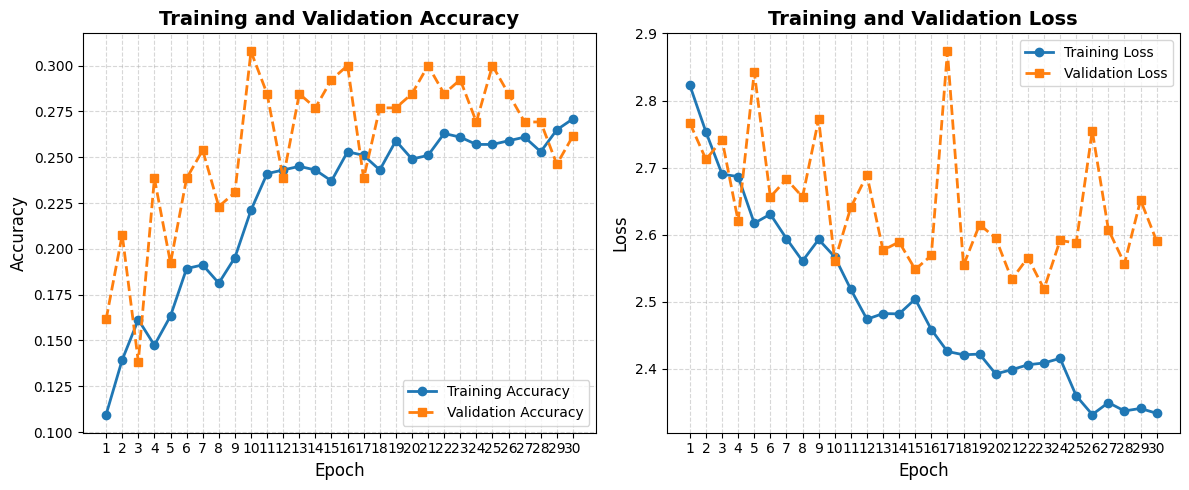

In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color = 'tab:blue', label = 'Training Accuracy', linewidth = 2, markersize = 6)
plt.plot(epochs, val_acc, 's--', color = 'tab:orange', label = 'Validation Accuracy', linewidth = 2, markersize = 6)
plt.title('Training and Validation Accuracy', fontsize = 14, fontweight = 'bold')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.xticks(epochs)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color = 'tab:blue', label = 'Training Loss', linewidth = 2, markersize = 6)
plt.plot(epochs, val_loss, 's--', color = 'tab:orange', label = 'Validation Loss', linewidth = 2, markersize = 6)
plt.title('Training and Validation Loss', fontsize = 14, fontweight = 'bold')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.xticks(epochs)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.tight_layout()
plt.show()


In [114]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    directory = new_dir + '/' + 'test',
    target_size = (120, 120),
    batch_size = 10,
    class_mode = 'categorical')

Found 172 images belonging to 18 classes.


In [115]:
test_loss, test_acc = model.evaluate(test_generator)

c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.2891 - loss: 2.4742


In [ ]:
test_acc

0.26744186878204346

In [117]:
pred_generator = test_datagen.flow_from_directory(
    directory = new_dir + '/' + 'test',
    target_size = (120, 120),
    batch_size = 10,
    class_mode=None,  # only data, no labels
    shuffle=False)  # keep data in same order as labels

Found 172 images belonging to 18 classes.


In [118]:
preds = model.predict(pred_generator)

c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [119]:
pred_generator.class_indices

{'Bug': 0,
 'Dark': 1,
 'Dragon': 2,
 'Electric': 3,
 'Fairy': 4,
 'Fighting': 5,
 'Fire': 6,
 'Flying': 7,
 'Ghost': 8,
 'Grass': 9,
 'Ground': 10,
 'Ice': 11,
 'Normal': 12,
 'Poison': 13,
 'Psychic': 14,
 'Rock': 15,
 'Steel': 16,
 'Water': 17}

In [120]:
classes = list(pred_generator.class_indices.keys())
classes

['Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water']

In [121]:
preds.shape

(172, 18)

In [122]:
pred_values = preds.argmax(axis = 1)
pred_values

array([12, 12,  6, 12, 12, 17, 15,  9, 12, 12, 14, 12,  0, 12, 15, 12, 17,
       12, 12, 12, 12, 12, 15, 12, 12, 12, 12, 12, 14, 12, 14, 17, 12,  0,
       15, 12, 12, 12, 12, 15, 12, 15, 12, 17, 12, 12,  0, 12, 12, 15,  6,
        6,  6,  0,  6,  6, 15,  6,  6,  6, 12, 12, 12, 17, 12, 12, 12, 14,
       17,  9,  9, 17, 12,  9,  9,  9, 17,  0, 15, 15, 15, 12,  9,  9, 15,
       12, 12, 15, 17, 12,  9, 17, 17, 16, 17, 13, 17, 12, 12, 12, 12, 12,
        0, 12, 12,  6,  9, 17, 12, 12, 12, 12, 12, 12, 12, 12, 15, 12, 12,
       17, 12, 14, 15, 15, 15, 12, 14, 17, 17, 12, 15, 12, 14, 15, 16, 17,
       17, 17,  9,  0, 12, 17, 17,  9, 12, 17, 15, 15, 12, 17, 12, 17,  9,
       12, 12, 17, 15, 15, 17, 17, 17, 12, 17, 12, 12, 17, 17, 15, 12, 17,
       17, 17])

In [124]:
preds_labels = np.array(classes)[pred_values]
preds_labels

array(['Normal', 'Normal', 'Fire', 'Normal', 'Normal', 'Water', 'Rock',
       'Grass', 'Normal', 'Normal', 'Psychic', 'Normal', 'Bug', 'Normal',
       'Rock', 'Normal', 'Water', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Rock', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Psychic', 'Normal', 'Psychic', 'Water', 'Normal', 'Bug', 'Rock',
       'Normal', 'Normal', 'Normal', 'Normal', 'Rock', 'Normal', 'Rock',
       'Normal', 'Water', 'Normal', 'Normal', 'Bug', 'Normal', 'Normal',
       'Rock', 'Fire', 'Fire', 'Fire', 'Bug', 'Fire', 'Fire', 'Rock',
       'Fire', 'Fire', 'Fire', 'Normal', 'Normal', 'Normal', 'Water',
       'Normal', 'Normal', 'Normal', 'Psychic', 'Water', 'Grass', 'Grass',
       'Water', 'Normal', 'Grass', 'Grass', 'Grass', 'Water', 'Bug',
       'Rock', 'Rock', 'Rock', 'Normal', 'Grass', 'Grass', 'Rock',
       'Normal', 'Normal', 'Rock', 'Water', 'Normal', 'Grass', 'Water',
       'Water', 'Steel', 'Water', 'Poison', 'Water', 'Normal', 

In [125]:
pred_generator.classes

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
        1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  8,  8,  8,  8,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13,
       13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17], dtype=int32)

In [126]:
true_values = pred_generator.classes
true_values

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
        1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  8,  8,  8,  8,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13,
       13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17], dtype=int32)

In [127]:
true_labels = np.array(classes)[true_values]
true_labels

array(['Bug', 'Bug', 'Bug', 'Bug', 'Bug', 'Bug', 'Bug', 'Bug', 'Bug',
       'Bug', 'Bug', 'Bug', 'Bug', 'Dark', 'Dark', 'Dark', 'Dark', 'Dark',
       'Dark', 'Dark', 'Dark', 'Dragon', 'Dragon', 'Dragon', 'Dragon',
       'Dragon', 'Dragon', 'Electric', 'Electric', 'Electric', 'Electric',
       'Electric', 'Electric', 'Electric', 'Electric', 'Electric',
       'Electric', 'Fairy', 'Fairy', 'Fairy', 'Fighting', 'Fighting',
       'Fighting', 'Fighting', 'Fighting', 'Fighting', 'Fire', 'Fire',
       'Fire', 'Fire', 'Fire', 'Fire', 'Fire', 'Fire', 'Fire', 'Fire',
       'Fire', 'Fire', 'Fire', 'Fire', 'Fire', 'Fire', 'Ghost', 'Ghost',
       'Ghost', 'Ghost', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Ground', 'Ground',
       'Ground', 'Ground', 'Ground', 'Ground', 'Ground', 'Ground', 'Ice',
       'Ice', 'Ice', 'Ice', 'Ice', 'Ice', 'Ice', 'Normal', 'Normal',
  

In [128]:
res = pd.DataFrame({'true':true_labels, 'predicted':preds_labels})

In [129]:
pd.set_option('display.max_rows', res.shape[0]+1)
res

,true,predicted
0,Bug,Normal
1,Bug,Normal
2,Bug,Fire
3,Bug,Normal
4,Bug,Normal
5,Bug,Water
6,Bug,Rock
7,Bug,Grass
8,Bug,Normal
9,Bug,Normal


In [130]:
from sklearn.metrics import confusion_matrix

In [131]:
cm = confusion_matrix(true_values, pred_values)
print(cm)

[[ 1  0  0  0  0  0  1  0  1  0  0  7  0  1  1  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  6  0  0  1  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  5  0  0  1  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  5  0  2  1  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  4  0  0  1  0  1]
 [ 2  0  0  0  0  0  8  0  0  0  0  4  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  1]
 [ 1  0  0  0  0  0  0  0  6  0  0  3  0  1  3  0  3]
 [ 0  0  0  0  0  0  0  0  2  0  0  3  0  0  2  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  1  4]
 [ 1  0  0  0  0  0  1  0  1  0  0 15  0  0  1  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  3  0  1  3  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  2  2  1  4]
 [ 1  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  2  0  0  9  0  0  5  0 14]]


In [140]:
pd.Series(classes)[np.invert(pd.Series(classes).isin(true_labels))]

7    Flying
dtype: object

There is no flying type in test data. So we remove it in showing the confusion matrix.

In [142]:
classes_corr = classes.copy()
classes_corr.remove('Flying')

In [144]:
df_cm = pd.DataFrame(cm, 
                     index = [c for c in classes_corr],
                     columns = [c for c in classes_corr])
df_cm

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
Bug,1,0,0,0,0,0,1,0,1,0,0,7,0,1,1,0,1
Dark,0,0,0,0,0,0,0,0,0,0,0,6,0,0,1,0,1
Dragon,0,0,0,0,0,0,0,0,0,0,0,5,0,0,1,0,0
Electric,1,0,0,0,0,0,0,0,0,0,0,5,0,2,1,0,1
Fairy,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0
Fighting,0,0,0,0,0,0,0,0,0,0,0,4,0,0,1,0,1
Fire,2,0,0,0,0,0,8,0,0,0,0,4,0,0,2,0,0
Ghost,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1
Grass,1,0,0,0,0,0,0,0,6,0,0,3,0,1,3,0,3
Ground,0,0,0,0,0,0,0,0,2,0,0,3,0,0,2,0,1


<Axes: >

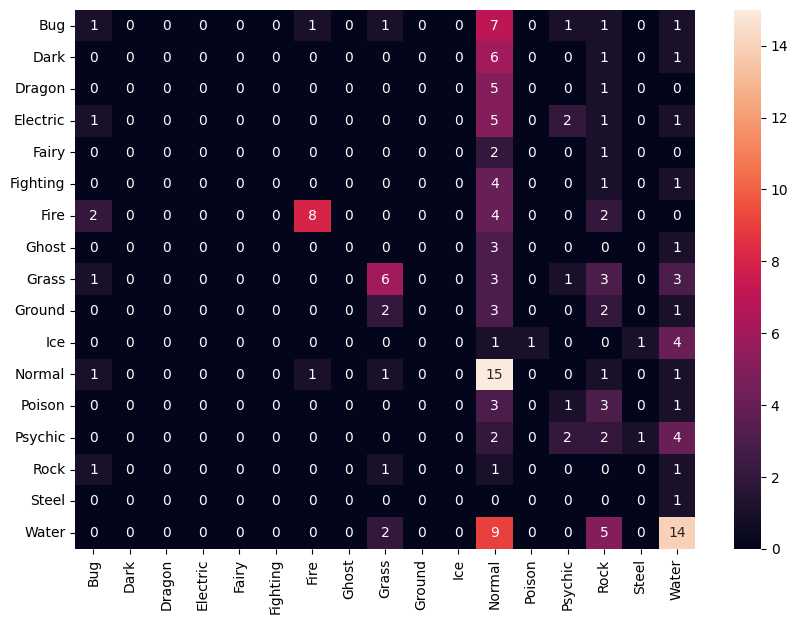

In [147]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

I should divide train, validation and test data by randomly splitting in each type category proportional to the relative sizes of the 3 datasets.
Also, I change the size proportion of the 3 sets by dividing in a different way.

I also rerun the model to reset the weights.

In [148]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (120, 120, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(300, activation = 'relu'))
model.add(layers.Dense(18, activation = 'softmax'))

model.summary()

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 11, 11, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 300)            │       960,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 18)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,550 (4.60 MB)

 Trainable params: 1,206,550 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

In [149]:
X_train, X_rem, y_train, y_rem = train_test_split(pkm['Name'], pkm['Type1'], 
                                                  test_size = 400, random_state = 1234,
                                                  stratify = pkm['Type1']) 
#I had to choose almost 0.5 to avoid error for too few class instances (I think the problem is the flying type)

X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, 
                                                test_size = 0.5, random_state = 1234,
                                                stratify = y_rem)

for df in [X_train, y_train, X_val, y_val, X_test, y_test]:
    print(len(df), end = '\n')

409
409
200
200
200
200


In [ ]:
new_dir2 = '../data/pokemon_image_keras_2'

image_keras_creator(pkm_img_path, new_dir2)

Unused: [] 



In [152]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory = new_dir2 + '/' + 'train',
    target_size = (120, 120),
    batch_size = 10,
    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
        directory = new_dir2 + '/' + 'validation',
        target_size = (120, 120),
        batch_size = 10,
        class_mode = 'categorical')

earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    patience = 20,
    verbose = 1,
    mode = 'auto'
)

csv_logger = CSVLogger('../output/logs/training_augmented.log',
                       separator=',', 
                       append=False)


Found 415 images belonging to 18 classes.
Found 205 images belonging to 18 classes.


In [153]:
history = model.fit(
      train_generator,
      steps_per_epoch = 41,
      epochs = 100,
      validation_data = validation_generator,
      validation_steps = 20,
      callbacks = [earlystop, csv_logger])

Epoch 1/100


c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.1023 - loss: 2.8261 - val_accuracy: 0.1300 - val_loss: 2.7350
Epoch 2/100
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.1000 - loss: 2.5439

c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1000 - loss: 2.5439 - val_accuracy: 0.1350 - val_loss: 2.8475
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.1188 - loss: 2.7528 - val_accuracy: 0.1300 - val_loss: 2.6971
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4000 - loss: 2.5445 - val_accuracy: 0.1350 - val_loss: 2.7268
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.1358 - loss: 2.7532 - val_accuracy: 0.1500 - val_loss: 2.6884
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3000 - loss: 2.7527 - val_accuracy: 0.1450 - val_loss: 2.6642
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.1376 - loss: 2.7052 - val_accuracy: 0.0800 - val_loss: 2.9658
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1000 - loss: 2.9481 - val_accuracy: 0.1600 - val_loss: 2.6265
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.1368 - loss: 2.6486 - val_accuracy: 0.1850 - val_l

In [154]:
model.save(models_folder + '/CNN_03.keras')

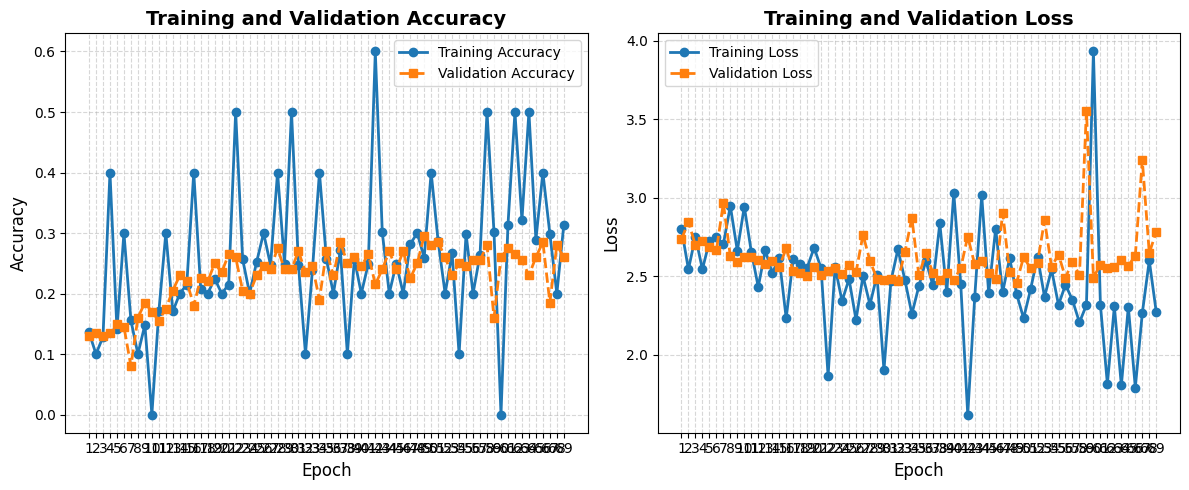

In [155]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color = 'tab:blue', label = 'Training Accuracy', linewidth = 2, markersize = 6)
plt.plot(epochs, val_acc, 's--', color = 'tab:orange', label = 'Validation Accuracy', linewidth = 2, markersize = 6)
plt.title('Training and Validation Accuracy', fontsize = 14, fontweight = 'bold')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.xticks(epochs)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color = 'tab:blue', label = 'Training Loss', linewidth = 2, markersize = 6)
plt.plot(epochs, val_loss, 's--', color = 'tab:orange', label = 'Validation Loss', linewidth = 2, markersize = 6)
plt.title('Training and Validation Loss', fontsize = 14, fontweight = 'bold')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.xticks(epochs)
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.tight_layout()
plt.show()

Type stratification was good. 

However, before I test on test data, I should train the model with also validation data, as follows.

In [156]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (120, 120, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(300, activation = 'relu'))
model.add(layers.Dense(18, activation = 'softmax'))

model.summary()

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=41,
      epochs=60)

history = model.fit(
      validation_generator,
      steps_per_epoch=20,
      epochs=60)


c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 11, 11, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 300)            │       960,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 18)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,206,550 (4.60 MB)

 Trainable params: 1,206,550 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60


c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.0698 - loss: 2.9334
Epoch 2/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - accuracy: 0.1000 - loss: 2.6417
Epoch 3/60
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.2000 - loss: 2.3083

c:\Users\sdifi\Proton Drive\stefano.difilippo\My files\Projects\MachineLearning_with_Pokemon\Python_code\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.1587 - loss: 2.7309
Epoch 4/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - accuracy: 0.0000e+00 - loss: 2.7483
Epoch 5/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.1635 - loss: 2.7532
Epoch 6/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - accuracy: 0.1000 - loss: 2.7065
Epoch 7/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.1468 - loss: 2.6878
Epoch 8/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - accuracy: 0.1000 - loss: 2.5956
Epoch 9/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.1821 - loss: 2.6757
Epoch 10/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - accuracy: 0.2000 - loss: 2.5462
Epoch 11/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.1743 - loss: 2.6350
Epoch 12/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.3000 - loss: 2.2522
Epoch 13/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.2146 - loss: 2.6070
Epoch 14/60
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - accuracy

In [157]:
model.save(models_folder + '/CNN_04.keras')

In [159]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    directory = new_dir + '/' + 'test',
    target_size = (120, 120),
    batch_size = 10,
    class_mode = 'categorical')

test_loss, test_acc = model.evaluate(test_generator)

test_acc 

Found 189 images belonging to 18 classes.


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2680 - loss: 5.3242


0.25925925374031067

In [160]:
def cm_keras_generator(pred_generator):
    preds = model.predict(pred_generator)
    classes = list(pred_generator.class_indices.keys())
    pred_values = preds.argmax(axis = 1)
    preds_labels = np.array(classes)[pred_values]
    true_values = pred_generator.classes
    true_labels = np.array(classes)[true_values]
    res = pd.DataFrame({'true':true_labels, 'predicted':preds_labels})
    cm = confusion_matrix(true_values, pred_values)
    df_cm = pd.DataFrame(cm, 
                     index = [c for c in classes],
                     columns = [c for c in classes])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    return res, df_cm

In [ ]:
pred_generator = test_datagen.flow_from_directory(
    directory = new_dir2 + '/' + 'test',
    target_size = (120, 120),
    batch_size = 10,
    class_mode=None,  # only data, no labels
    shuffle=False)  # keep data in same order as labels

Found 189 images belonging to 18 classes.


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


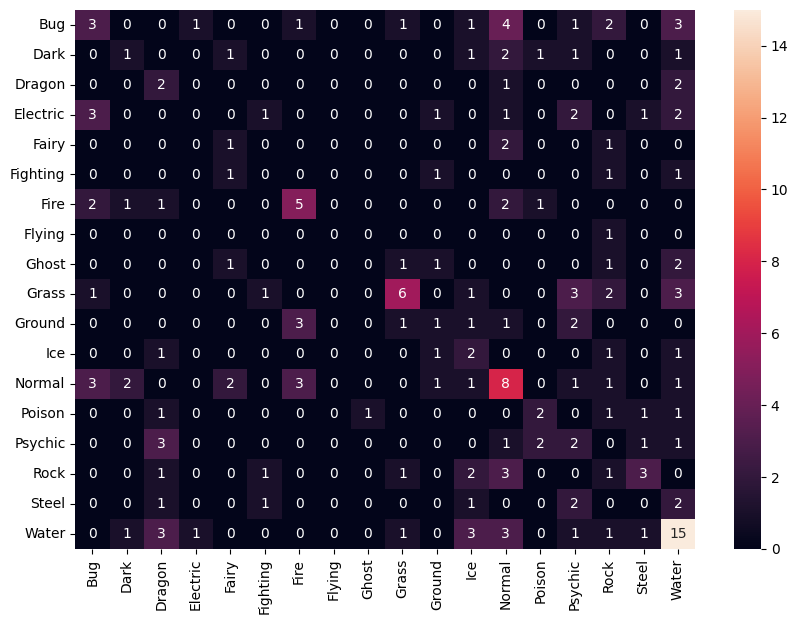

In [162]:
res, df_cm = cm_keras_generator(pred_generator)